In [2]:
VOCABULARY_SIZE = 2137

In [3]:
# basic imports
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers

Using TensorFlow backend.


In [4]:
# a NLP library
# get pretrained model with embeddings and load

# if GPU is on, Internet connection is needed in Kaggle Kernels!
!python -m spacy download en_core_web_lg

import spacy
nlp = spacy.load('en_core_web_lg')


    Linking successful
    /opt/conda/lib/python3.6/site-packages/en_core_web_lg -->
    /opt/conda/lib/python3.6/site-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [5]:
### plotting ###
# prettier and larger basic graphs
sns.set(rc={
    'figure.figsize':(18,8),
    'axes.titlesize':14,
})

### pandas ###
# no need to see many decimal places and makes nicer horizontal fits :-)
pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.precision = 3
# make the tables more compact vertically, too
pd.options.display.max_rows = 20

### numpy ###
# same as for pandas - max. 3 decimal places
np.set_printoptions(formatter={'float_kind':'{:.3f}'.format})
# np.set_printoptions(precision=3)

In [6]:
print(os.listdir("../input"))

['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


In [7]:
reviews_df = pd.read_csv('../input/drugsComTrain_raw.csv')
reviews_df

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [8]:
reviews_test_df = pd.read_csv('../input/drugsComTest_raw.csv')
reviews_test_df

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,3-Jul-14,13
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,21-Apr-09,32
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,18-Oct-16,21
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,16-Apr-11,3


The reviews are quite raw (containing unhealthy things for tokenizers such as `&#039;` *- an HTML code for apostrophe*),
I will quickly cook them a bit before progressing further...

In [9]:
## sanitizing review text

from html import unescape

def clean_review(text):
    """Replace HTML escaped characters
    and strip outer quotes and spaces"""
    return unescape(text.strip(' "\'')).replace('\r', ' ').replace('\n', ' ').replace('\ufeff1', '')

reviews_df.review = reviews_df.review.apply(clean_review)
reviews_test_df.review = reviews_test_df.review.apply(clean_review)

Today we have a soup made mostly with the following ingredients

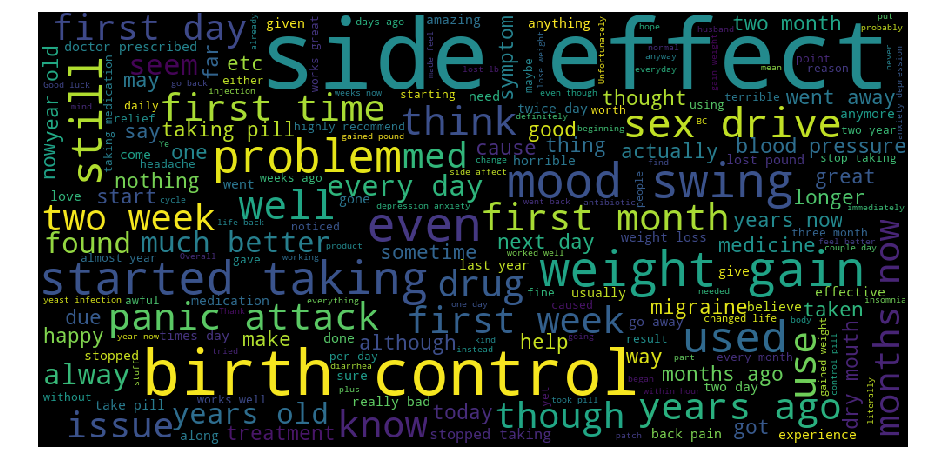

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=1000,
    height=500,
    random_state=hash('yummy'),
    max_font_size=110
)
wordcloud.generate('\n'.join(reviews_df.review))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
del wordcloud

In [11]:
## lemmatizing review text

def text2lexemes(text):
    """tokenize -> lemmatize"""
    
    tokens = nlp(
        # also split on "/"
        text.replace('/', ' / '),
        # we only need tokenizer and lemmas, so disable the rest
        disable=['tagger', 'parser', 'ner']
    )
    
    lexemes = []
    for token in tokens:
        
        if nlp.vocab[token.lemma_.lower()].has_vector:
            lexeme = token.lemma_.lower()
        elif nlp.vocab[token.norm_.lower()].has_vector:
            lexeme = token.norm_.lower()
        else:
            lexeme = token.lower_
        
        lexemes.append(lexeme)
        
    return lexemes

reviews_word_seq = [text2lexemes(review) for review in reviews_df.review]

In [12]:
# vocabulary map
# count occurences of each word
word_count = {}
for lemmas in reviews_word_seq:
    for lemma in lemmas:
        word_count[lemma] = word_count.get(lemma, 0) + 1
word_count = dict(sorted(word_count.items(), key=lambda pair: pair[1], reverse=True))

In [13]:
word_count

{'.': 862552,
 'i': 856875,
 'be': 587319,
 'have': 455315,
 'and': 431685,
 ',': 426565,
 'the': 407117,
 'a': 366904,
 'to': 323632,
 'it': 317498,
 'my': 292527,
 'for': 201810,
 'not': 188062,
 'of': 171731,
 ' ': 170331,
 'this': 144229,
 'on': 136947,
 'take': 132159,
 'in': 126630,
 'but': 123481,
 'me': 115680,
 'that': 113610,
 'do': 112851,
 'with': 104883,
 'day': 97560,
 '!': 92287,
 'get': 87593,
 'so': 82912,
 'feel': 71091,
 'month': 69045,
 'go': 66720,
 'year': 65793,
 'at': 64404,
 'after': 63125,
 'much': 62738,
 'no': 60163,
 'work': 59198,
 'week': 58003,
 'effect': 56208,
 'about': 55990,
 'now': 55275,
 'side': 53950,
 'start': 53900,
 'can': 53163,
 'time': 51161,
 'all': 49929,
 'pain': 48406,
 '2': 48106,
 '-': 46240,
 ')': 45716,
 'mg': 45618,
 'first': 45032,
 '(': 44472,
 'you': 43459,
 'only': 42753,
 'like': 42747,
 'up': 42449,
 'pill': 41760,
 'would': 41539,
 'period': 40085,
 'just': 40081,
 'very': 39785,
 'use': 39626,
 'out': 38713,
 '3': 38354,
 '

In [14]:
stop_words = nlp.Defaults.stop_words
stop_words.update(' .,()')
word_count_trimmed = dict(filter(lambda kv: kv[0] not in stop_words, word_count.items()))

In [15]:
word_count_trimmed

{'day': 97560,
 '!': 92287,
 'feel': 71091,
 'month': 69045,
 'year': 65793,
 'work': 59198,
 'week': 58003,
 'effect': 56208,
 'start': 53900,
 'time': 51161,
 'pain': 48406,
 '2': 48106,
 '-': 46240,
 'mg': 45618,
 'like': 42747,
 'pill': 41760,
 'period': 40085,
 'use': 39626,
 '3': 38354,
 'good': 38332,
 'try': 34155,
 'help': 33785,
 'medication': 31753,
 'doctor': 31189,
 '/': 29243,
 'little': 29114,
 'weight': 27673,
 'medicine': 25542,
 'life': 25473,
 'experience': 25195,
 'bad': 24569,
 'stop': 24541,
 'anxiety': 24169,
 'sleep': 23791,
 'think': 22956,
 'control': 22714,
 'hour': 22250,
 '4': 21931,
 '"': 20931,
 'night': 20744,
 'gain': 20435,
 '5': 20321,
 '10': 19844,
 'great': 19563,
 'drug': 18932,
 'cramp': 18863,
 'wrong': 18298,
 'dose': 18261,
 'long': 17976,
 'ago': 17678,
 'thing': 17596,
 'lose': 17243,
 'acne': 16976,
 '1': 16821,
 'birth': 16796,
 'prescribe': 16712,
 'depression': 16255,
 '6': 16092,
 'know': 15761,
 'come': 15507,
 'bleed': 15360,
 'eat': 1

In [16]:
## word sequence to integer sequences

vocab = list(word_count_trimmed)[:VOCABULARY_SIZE]
word2index = {word:index for index, word in enumerate(vocab, start=1)}

hash_word = lambda word: hash(word)%VOCABULARY_SIZE
hash_spacy = lambda word: nlp.vocab[word].orth

word_index2spacy_hash = {
    index:hash_spacy(word)
    for word, index in word2index.items()
}
word_hash2spacy_hash = {
    hash_word(word):hash_spacy(word)
    for word in vocab
}

reviews_seq = [
    [
        word2index.get(word, 0)
        for word in review
#         # dismiss out-of-vocabulary words
#         if word in word2index
    ]
    for review in reviews_word_seq
]

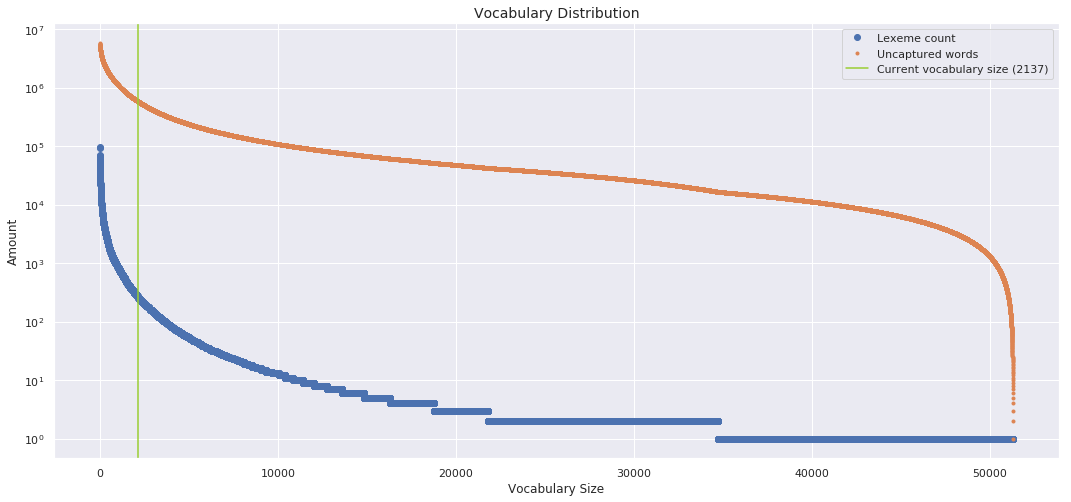

In [17]:
plt.title('Vocabulary Distribution')

wc_vals = list(word_count_trimmed.values())

# plt.plot(vf, '.', label='Words how they came')
plt.plot(wc_vals, 'o', label='Lexeme count')
plt.plot(sum(wc_vals)-np.cumsum(wc_vals), '.', label='Uncaptured words')
plt.axvline(x=VOCABULARY_SIZE, color='yellowgreen', label=f'Current vocabulary size ({VOCABULARY_SIZE})')

plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')

plt.legend()
plt.xlabel('Vocabulary Size')
plt.ylabel('Amount')

plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


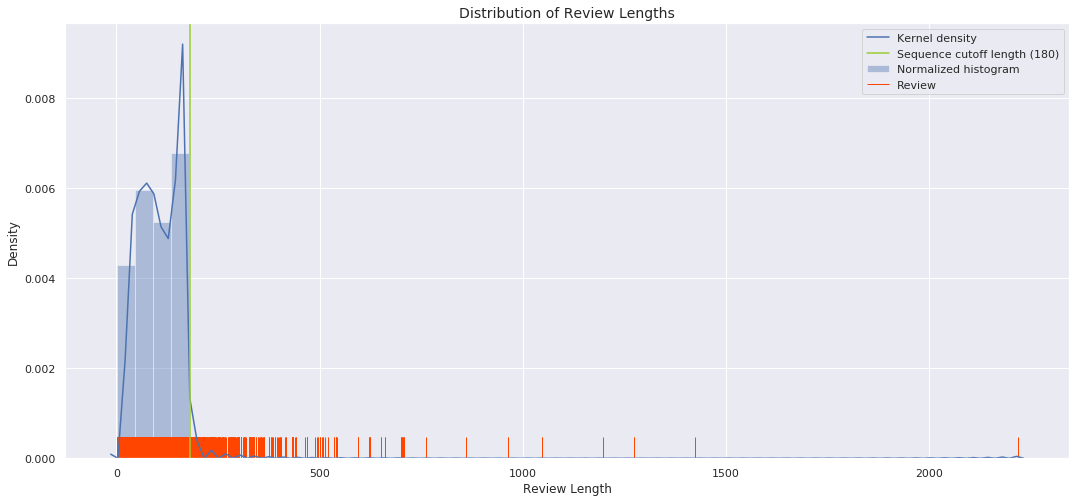

In [18]:
plt.title('Distribution of Review Lengths')

review_lengths = np.array([len(s) for s in reviews_seq])

sequence_cutoff_legth = int(np.quantile(review_lengths, 0.99))

sns.distplot(
    review_lengths,
    hist_kws=dict(label='Normalized histogram'),
    kde=True,
    kde_kws=dict(label='Kernel density'),
    rug=True,
    norm_hist=False,
    rug_kws=dict(color='orangered', label='Review'),
    axlabel='Sequence Length',
)
plt.axvline(
    x=sequence_cutoff_legth,
    color='yellowgreen',
    label=f'Sequence cutoff length ({sequence_cutoff_legth})'
)

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.legend();

In [19]:
## pad the sequences

reviews_seq = keras.preprocessing.sequence.pad_sequences(
    reviews_seq,
    maxlen=sequence_cutoff_legth
)

In [20]:
## scale values

# range will be 0.1 - 1.0
# very easy interpretation for the MAE metrics
reviews_df.rating /= 10

# standard scaling
reviews_df.usefulCount += reviews_df.usefulCount.mean()
reviews_df.usefulCount /= reviews_df.usefulCount.std()

In [21]:
# plotting

def plot_history(history, skip_first_n_epochs=0):
    """Show information about the training"""
    
    # plot every train-valid metric pair separately
    for metric in history:
        if not metric.startswith('val_'):
            x = np.arange(len(history[metric]))+1

            y_train = history[metric][skip_first_n_epochs:]
            y_valid = history['val_'+metric][skip_first_n_epochs:]

            # make the plots
            plt.plot(x, y_train)
            plt.plot(x, y_valid)

            # add a legend
            plt.legend([metric, 'val_'+metric], fontsize='large')

            # title with min/max stats
            plt.title(
                f'{metric.upper()} - '
                f'min/max [train: {min(y_train):.3f}/{max(y_train):.3f}, '
                f'valid: {min(y_valid):.3f}/{max(y_valid):.3f}]'
            )
            
            # label and show
            plt.xlabel('epoch')
            plt.show()

In [22]:
embedding_weights = np.zeros((
    VOCABULARY_SIZE+1, # indices/hashes
    nlp.vocab.vectors_length # embedding dimmension
))
for word, index in word2index.items():
    embedding_weights[index] = nlp.vocab[word].vector

In [23]:
input_reviews = layers.Input(shape=(sequence_cutoff_legth,), dtype='int32')

branch_a = layers.Embedding(VOCABULARY_SIZE+1, output_dim=256)(input_reviews)
branch_a = layers.GaussianNoise(0.05)(branch_a)
branch_a = layers.CuDNNLSTM(128)(branch_a)
branch_a = layers.Dense(10, activation='relu')(branch_a)
branch_a = layers.BatchNormalization()(branch_a)
branch_a = layers.Dropout(0.1)(branch_a)

input_useful_count = layers.Input(shape=(1,))

model_top = layers.concatenate([branch_a, input_useful_count])
model_output = layers.Dense(1, activation='sigmoid')(model_top)

model = keras.models.Model(
    inputs=[input_reviews, input_useful_count],
    outputs=model_output,
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 180, 256)     547328      input_1[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 180, 256)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 128)          197632      gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
dense_1 (D

In [24]:
x_train = [
    reviews_seq,
    reviews_df.usefulCount.values,
]
y_train = reviews_df.rating.values

In [25]:
model.compile(
    optimizer='adam',
    loss='mae',
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=120,
    verbose=1,
    validation_split=0.25,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            'model-epoch_{epoch:02d}-val_loss_{val_loss:.2f}.hdf5',
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            period=1,
        ),
    ],
)

plot_history(history.history)

In [ ]:
x = x_train
y = y_train
y, (*x) = zip(*sorted(zip(y, *x), key=lambda pair: pair[0]))
yh = model.predict(x).ravel()

plt.plot(y, '.')
plt.plot(yh, '.');